# Finite State Machine

References:
- [Context Managers and Python's with Statement](https://realpython.com/python-with-statement/)

Let $x_t$ be the stochastic process:

$$
dx_t=\mu dt+\sigma dw_t
$$

This kind of diffusion processes is called Wiener process.

We want to model $x_t$ with trend and flat behaviors. We call a process flat, if $\mu=0$, otherwise the process is called trend. There are two scenarios for trend processes, trend up and trend down, in which casees, the model parameter $\mu$ are positive and negative repectively. The flat process is also called Brownian motion and the trend process is Brown motion with drift.

With the above setting, there are three different contexts for the Wiener process, the context of flat, the context of up trend and the context of down trend. To model a Wiener process having three different contexts is to make the parameter $\mu$ depending on the hidden states that representing the contexts.

Let $S_t$ be the state process, where $S_t\in [-1,0,1]$, in other words, $S_t$ is a three states process, $-1$ corresponding to down trend, $0$ for flat and $1$ for trend up.

The fact that $\mu$ depends $S_t$, makes the law governing the process $x_t$ change over time according to the contexts that dictated by the state process. This kind of processes are called hidden markov processes.

In summary, we have

$$
dx_t=\mu(S_t) dt+\sigma dW_t
$$

with $S_t$ being a state process. The law governing $S_t$ is the transition probabilities, $P\{S_{t_i}=u\ |\ S_{t_{i-1}}=v\},\ u,v\in[-1,0,1]$. These probabilities are not depending on time.

We are going to develop a discrete simulator to simulate the hidden markov Wiener process $x_t$.


In [1]:
from contextlib import contextmanager

@contextmanager
def hello_context_manager():
    print("Entering the context...")
    yield "Hello, World!"
    print("Leaving the context...")

with hello_context_manager() as hello:
    print(hello)

Entering the context...
Hello, World!
Leaving the context...


### The dependent models

In [2]:
import numpy as np
from nptyping import NDArray, Shape, Float64
from typing import Literal, Final, Protocol, runtime_checkable
from dataclasses import dataclass

WienerParam=tuple[float,float]
StateParam=NDArray[Shape['3,3'],Float64]
State=Literal[-1,0,1]

In [3]:
print(StateParam)

NDArray[Shape['3, 3'], Float]


In [4]:
@dataclass
class Wiener:
    wparams: list[WienerParam]

@dataclass
class FSMarkov:
    tranprobs: StateParam

# finite state markov model information interface
class FSMarkovInfo(Protocol):
    def transition(self,start:State, end:State)->list[float]: ...
    def states(self)->list[State]: ...
    def str2state(self,name:str)->State: ...

# diffusion process model information interface
class WienerInfo(Protocol):
    def Wiener(self,s:int)->WienerParam: ...

### Simulator interfaces

In [5]:
class FSMarkovSimulator(Protocol):
    def sim_state(self,s:State)->tuple[int,State]: ...

class WienerSimulator(Protocol):
    def sim_Wiener(self,x0:float)->list[float]: ...

### The core model
- a Wiener process model (an object of `Wiener` data class)
- a finite state markove model (an object of `FSMarkov` data class)
- Implements the `FSMarkovSimulator` interface
- Implements the `FSMarkovInfo` interface
- Implements the `WienerInfo` interface
- Implements the `WienerSimulator` interface

In [6]:
class HiddenMarkov():
    def __init__(self,dp:Wiener,sp:FSMarkov):
        self.dp=dp
        self.fsm=sp
    SV:Final[list[State]]=[-1,0,1]; INTERVAL_A:Final[int]=1;INTERVAL_B:Final[int]=1000
    AB:Final[int]=INTERVAL_B-INTERVAL_A
    def transition(self,start:State, end:State)->list[float]:
        if start in self.SV and end in self.SV: return self.fsm.tranprobs[start+1][end+1]
        else: raise ValueError("Illegal state value")
    def states(self)->list[State]: return self.SV
    def str2state(self,name:str)->State:
        match name:
            case 'downtrend': return -1
            case 'uptrend': return 1
            case 'flat': return 0
            case _: raise ValueError("Unknow state name")
        
    def sim_state(self,s:State)->State:
        rn=np.random.randint(self.INTERVAL_A,self.INTERVAL_B)
        p=self.fsm.tranprobs[s+1]
        if rn<self.AB*p[0]: return self.SV[0]
        elif rn<=self.AB*(p[1]+p[0]): return self.SV[1]
        else: return self.SV[2]

    def wiener(self,s:int)->WienerParam: return self.dp.wparams[s+1]

    def sim_wiener(self,x0:float)->list[float]:
        return []

In [7]:
MP=Wiener([(-1.0,20.0),(0.0,30.0),(1.0,20.0)]) # diffusion process
TP=FSMarkov(np.array([[.25,.75,0.0],[.15,.7,.15],[0.0,.75,.25]])) # finite state markov process
m=HiddenMarkov(MP,TP)

In [8]:
[[m.transition(start,end) for end in m.states()] for start in m.states()]

[[0.25, 0.75, 0.0], [0.15, 0.7, 0.15], [0.0, 0.75, 0.25]]

In [9]:
[m.wiener(s) for s in m.states()]

[(-1.0, 20.0), (0.0, 30.0), (1.0, 20.0)]

## Simulating the state process

In [10]:
from typing import Generator
from itertools import takewhile

@contextmanager
def single_state_simulator(s:State,m:FSMarkovSimulator,verbal:bool=False)->Generator:
    if verbal:
        print("Entering the flat state...")
        print("State transition probabilites:",[m.transition(s,x) for x in m.states()])
    state=s; n=0; new_state=state
    while new_state==state: new_state=m.sim_state(state);n+=1

    yield (n,new_state)

    if verbal: print(f"leaving the {state} state")

In [11]:
np.random.seed(0)
N=pow(2,13)

def single_state_process(s:State,m:FSMarkovSimulator,verbal=False)->tuple[int,State]:
    with single_state_simulator(s,m,verbal) as fs:
        return tuple(fs)

### Checking random number generator
The simulated state appearing frequencies are close to the transition probablities, the errors are around in the order of $10^{-3}$ for $2^{13}$ realizations:

In [12]:
[
    list(map(
            lambda s: # computing the frequency of the transition to state s for state v
                len(list(
                    filter(lambda x:x==s,[m.sim_state(v) for _ in range(N)])
                ))/N,
            m.states() # for all possible transition states
        )
    )
    for v in m.states() # the state v visits all possible state in m.states()
]

[[0.2506103515625, 0.753662109375, 0.0],
 [0.146728515625, 0.7071533203125, 0.158447265625],
 [0.0, 0.7509765625, 0.25146484375]]

### Simulating single state processes
Using the transition proabability, compute the length of the current state before entering the next state.

In [13]:
single_state_process(m.str2state('flat'),m,True)

Entering the flat state...
State transition probabilites: [0.15, 0.7, 0.15]
leaving the 0 state


(1, -1)

`N` realizations for the flat state process:

In [14]:
fps=[single_state_process(m.str2state('flat'),m) for _ in range(N)]

In [15]:
fps[:20]

[(5, -1),
 (4, 1),
 (1, 1),
 (2, -1),
 (3, 1),
 (3, -1),
 (1, 1),
 (6, 1),
 (2, 1),
 (1, -1),
 (2, -1),
 (7, -1),
 (5, -1),
 (2, -1),
 (2, -1),
 (4, -1),
 (1, 1),
 (2, -1),
 (1, -1),
 (13, 1)]

`N` realizations for the uptrend state process:

In [16]:
uts=[single_state_process(m.str2state('uptrend'),m) for _ in range(N)]

In [17]:
uts[:20]

[(2, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (3, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0)]

`N` realizations for the downtrend state process:

In [18]:
dts=[single_state_process(m.str2state('downtrend'),m) for _ in range(N)]

In [19]:
dts[:20]

[(2, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (1, 0)]

### Full process simulation
We are testing several implementation as follows.
- Using while loop: easier to read (maybe), utilize the components developed earlier.
- Using `foldl`: tight and clean, can skip all the components developed earlier, but few times slower than the while loop.
- Using caching technique on `foldl`: dramatically improves the peformance.

In [20]:
def state_process_w(s0:State,m:HiddenMarkov,length:int)->list[State]:
    process=[]
    while len(process)<length:
        l,ns=single_state_process(s0,m)
        process+=[s0]*l
        s0=ns
    return process[:length]

In [21]:
%%timeit
s=state_process_w(m.str2state('flat'),m,N)

46.4 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%time
s=state_process_w(0,m,N)

CPU times: user 39.4 ms, sys: 3.13 ms, total: 42.5 ms
Wall time: 42 ms


In [23]:
from itertools import repeat
from Contexts.Functor import ListFunctor
from Contexts.Foldable import foldl
v=list(repeat(1,N))

In [24]:
def state_process(s0:State,m:HiddenMarkov,N:int)->list[State]:
    return foldl(lambda acc,x:(m.sim_state(acc[0]),acc[1]+[acc[0]]),(s0,[]),repeat(1,N))[1]

In [25]:
%%timeit
s=state_process(0,m,N)

116 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
%%time
s=state_process(0,m,N)

CPU times: user 105 ms, sys: 7.04 ms, total: 112 ms
Wall time: 112 ms


In [27]:
from functools import lru_cache

@lru_cache(maxsize=128, typed=False)
def state_process_cache(s0:State,m:HiddenMarkov,N:int)->list[State]:
    return foldl(lambda acc,x:(m.sim_state(acc[0]),acc[1]+[acc[0]]),(s0,[]),repeat(1,N))[1]

In [28]:
%%timeit
s=state_process_cache(0,m,N)

77.8 ns ± 2.81 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [29]:
%%time
s=state_process_cache(0,m,N)
s[:20]

CPU times: user 23 µs, sys: 3 µs, total: 26 µs
Wall time: 30.8 µs


[0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]

## Simulating Wiener processes
The discrete form of the Wiener process can be written as:

$$x_i=x_{i-1}+\mu \Delta t_i+\sigma\sqrt{\Delta t_i}\xi_i$$

where $\xi\sim N(0,1)$.

In [30]:
import math
mu=1.0; sigma=20.0; x0=0.0; dt=1.0/365; N=pow(2,13); sqrtdt=math.sqrt(dt)
foo=foldl(lambda acc,xi:(tmp:= acc[0]+mu*dt+sigma*sqrtdt*xi,acc[1]+[tmp]),(0.0,[]),np.random.normal(0.0,1.0,N))

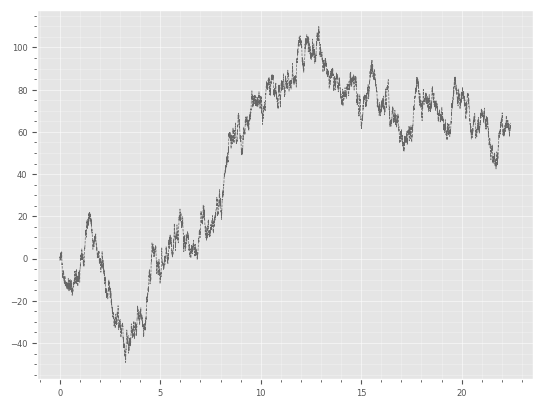

In [31]:
import matplotlib.pyplot as plt
from plot.qiplot import plot_ts
plt.style.use(['ggplot','../plot/presentation.mplstyle'])

t=[dt*i for i in range(N)]
x=foo[1]
fig,ax=plt.subplots()
plot_ts(ax,t,x)

## Simulating a hidden markov process

## Model estimations

### Estimating the finite state markov process
Given a simulated process $\{s_i\}_{i=1}^N,\ s_i\in S$, where $S$ is the state space, in this implementation,
$S=\{-1,0,1\}$ representing the down trend, flat and up trend repectively.

From the observed sequence $\{s_i\}_{i=1}^N$, we want to estimate the transitioin probablilites $p(S_v,S_u)=P\{s_i=S_u\ |\ s_{i-1}=S_v\}, i=1,\cdots,N, S_u,S_v\in S$. For a given $S_u, S_v\in S$, the estimator is as follows:
- Compute the number of occuring of the event $\{s_i=S_u\ |\ s_{i-1}=S_v\}$ in the sequence $\{s_i\}_{i=1}^N$.
- Compute the number of the occuring of the event $\{s_i=S_v\}$.
- The estimated transition probabability $p(S_v,S_u)$ is the ratio of the above two quantities.

This estimator is coded in the function `transition_pair_estimator`:
- `s1`: $S_v$
- `s2`: $S_u$
- `s0`: the initial value of the finite state markov process
- `s`: a realization of the finite state markov process

In [32]:
def transition_pair_estimator(s1:State,s2:State,s0:State,s:list[State])->float:
    N=len(list(filter(lambda x:x==s1,s)))
    return sum(foldl(lambda acc,x:(x,acc[1]+[1]) if acc[0]==s1 and x==s2 else (x,acc[1]),(s0,[]),s)[1])/N

In [33]:
s=state_process(0,m,pow(2,13))

In [34]:
transition_pair_estimator(-1,0,0,s)

0.751269035532995

In [35]:
[[transition_pair_estimator(s1,s2,0,s) for s2 in m.states()] for s1 in m.states()]

[[0.24873096446700507, 0.751269035532995, 0.0],
 [0.150559511698881, 0.7044760935910478, 0.14496439471007122],
 [0.0, 0.7688848920863309, 0.23111510791366907]]

Comparing to the model parameters:

In [36]:
[[m.transition(start,end) for end in m.states()] for start in m.states()]

[[0.25, 0.75, 0.0], [0.15, 0.7, 0.15], [0.0, 0.75, 0.25]]

The erros are in the order of $10^{-2}$ from a realization of the process with length $2^{13}$.

Let's increase the length of the process to $2^{16}$ and check the result:

In [37]:
s=state_process(0,m,pow(2,16))
[[transition_pair_estimator(s1,s2,0,s) for s2 in m.states()] for s1 in m.states()]

[[0.24518053040792417, 0.7548194695920758, 0.0],
 [0.15124095691329306, 0.7016154847521288, 0.1471435583345782],
 [0.0, 0.7423557278208441, 0.2576442721791559]]

The errors are now in the order of $10^{-3}$, not a big gain in precision but it does gain.

### Estimating Wiener processes
Since the process $x_i$ statisfying

$$x_i=x_{i-1}+\mu\Delta t+\sigma\sqrt{\Delta}\xi_i$$

where $\xi\sim N(0,1)$.

We have $\Delta x_i=x_i-x_{i-1}\sim N(\mu\Delta t,\sigma\sqrt{\Delta t})$, for $i=1,2,\cdots,N$, so the unbiased estimator for this normal distribution is as follows:

$$\mu\Delta t=\frac{1}{N}\sum_{i=1}^N \Delta x_i$$

and

$$\sigma\sqrt{\Delta t}=\sqrt{\frac{1}{N-1}\sum_{i=1}^N\Delta^2x_i}$$

In [38]:
mu=1.0; sigma=20.0; x0=0.0; dt=1.0/365; N=pow(2,13); sqrtdt=math.sqrt(dt)
x=foldl(lambda acc,xi:(tmp:= acc[0]+mu*dt+sigma*sqrtdt*xi,acc[1]+[tmp]),(0.0,[]),np.random.normal(0.0,1.0,N))[1]

In [39]:
from scipy.stats import norm

In [40]:
dx=foldl(lambda acc,x:(x,acc[1]+[x-acc[0]]),(0.0,[]),x)[1]

In [41]:
mudt,stddt=norm.fit(dx)

In [42]:
print(mudt/dt,stddt/sqrtdt)

-0.35603251090124766 19.768171448769042


It is hard to get a good estimation on the drift $\mu$, but relatively easy to estimate the variance $\sigma$ of the process.